# SimMIM Test on Oxford IIIT Pets

In [75]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T

from vit import ViT
from simmim import SimMIM
from utils import OxfordIIITPetsAugmented, ToDevice, get_device

import matplotlib.pyplot as plt

## Initialise ViT model and load data

In [94]:
# Define some transformations for the Oxford IIIT Pet dataset
def tensor_trimap(t):
	x = t * 255
	x = x.to(torch.long)
	x = x - 1
	return x

def args_to_dict(**kwargs):
	return kwargs

transform_dict = args_to_dict(
	pre_transform=T.ToTensor(),
	pre_target_transform=T.ToTensor(),
	common_transform=T.Compose([
		ToDevice(get_device()),
		T.Resize((128, 128), interpolation=T.InterpolationMode.NEAREST),
		# Random Horizontal Flip as data augmentation.
		T.RandomHorizontalFlip(p=0.5),
	]),
	post_transform=T.Compose([
		# Color Jitter as data augmentation.
		T.ColorJitter(contrast=0.3),
	]),
	post_target_transform=T.Compose([
		T.Lambda(tensor_trimap),
	]),
)

# Download Oxford-IIIT Pet Dataset - train and test sets
trainset = OxfordIIITPetsAugmented(
	root='data',
	split="trainval",
	target_types="segmentation",
	download=True,
	**transform_dict,
)
testset = OxfordIIITPetsAugmented(
	root='data',
	split="test",
	target_types="segmentation",
	download=True,
	**transform_dict,
)

trainloader = torch.utils.data.DataLoader(
		trainset,
		batch_size=128,
		shuffle=True,
)
testloader = torch.utils.data.DataLoader(
	testset,
	batch_size=128,
	shuffle=True,
)

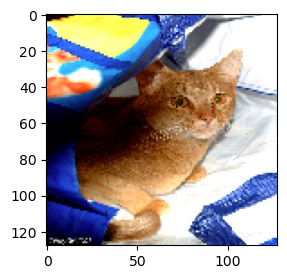

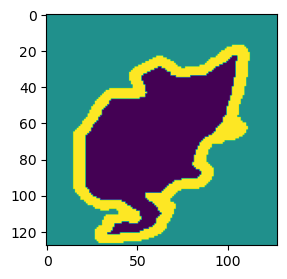

In [95]:
# Display a sample train image and its corresponding target
(train_image, train_target) = trainset[0]

plt.figure(figsize=(3,3))
plt.imshow(train_image.permute(1, 2, 0))
plt.show()

plt.figure(figsize=(3,3))
plt.imshow(train_target.squeeze(0))
plt.show()

## Define ViT and train SimMIM model

In [128]:
model = ViT(
    image_size = 128,
    patch_size = 32,
    num_classes = 37,
    dim = 384,
    depth = 12,
    heads = 6,
    mlp_dim = 1536
)

# Print number of parameters
print('Number of parameters:', sum(p.numel() for p in model.parameters()))

Number of parameters: 22488613


In [129]:
mim = SimMIM(
    encoder = model,
    masking_ratio = 0.5  # they found 50% to yield the best results
)
optimizer = optim.AdamW(
		params=mim.parameters(),
		lr=8e-4,
		weight_decay=5e-2
)

n_epochs = 100
for i in range(n_epochs):
    j = 0
    running_loss = 0.0
    for images, _ in trainloader:
        print(f'Epoch {i} | Batch {j}')
        j += 1

        loss, pred, masks = mim(images)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        running_loss += loss.item()

    print(f'Epoch {i} - Loss: {running_loss / len(trainloader)}')



Epoch 0 | Batch 0
Epoch 0 | Batch 1
Epoch 0 | Batch 2
Epoch 0 | Batch 3
Epoch 0 | Batch 4
Epoch 0 | Batch 5
Epoch 0 | Batch 6
Epoch 0 | Batch 7
Epoch 0 | Batch 8
Epoch 0 | Batch 9
Epoch 0 | Batch 10
Epoch 0 | Batch 11
Epoch 0 | Batch 12
Epoch 0 | Batch 13
Epoch 0 | Batch 14
Epoch 0 | Batch 15
Epoch 0 | Batch 16
Epoch 0 | Batch 17
Epoch 0 | Batch 18
Epoch 0 | Batch 19
Epoch 0 | Batch 20
Epoch 0 | Batch 21
Epoch 0 | Batch 22
Epoch 0 | Batch 23
Epoch 0 | Batch 24
Epoch 0 | Batch 25
Epoch 0 | Batch 26
Epoch 0 | Batch 27
Epoch 0 | Batch 28
Epoch 0 - Loss: 0.033988593274663234
Epoch 1 | Batch 0
Epoch 1 | Batch 1
Epoch 1 | Batch 2
Epoch 1 | Batch 3
Epoch 1 | Batch 4
Epoch 1 | Batch 5
Epoch 1 | Batch 6
Epoch 1 | Batch 7
Epoch 1 | Batch 8
Epoch 1 | Batch 9
Epoch 1 | Batch 10
Epoch 1 | Batch 11
Epoch 1 | Batch 12
Epoch 1 | Batch 13
Epoch 1 | Batch 14
Epoch 1 | Batch 15
Epoch 1 | Batch 16
Epoch 1 | Batch 17
Epoch 1 | Batch 18
Epoch 1 | Batch 19
Epoch 1 | Batch 20
Epoch 1 | Batch 21
Epoch 1 | Batc

## Display a test image and evaluate SimMIM on it

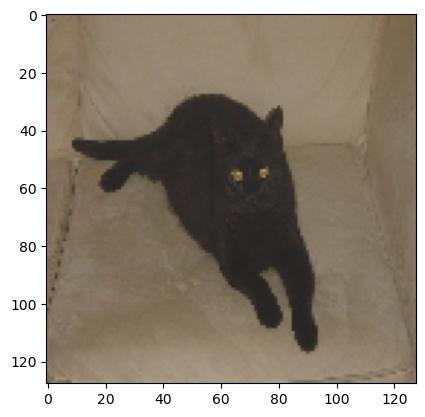

In [248]:
test_images, test_targets = next(iter(testloader))
plt.imshow(test_images[20].permute(1, 2, 0))

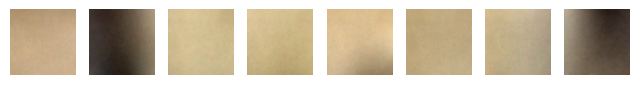

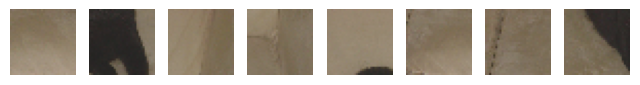

In [249]:
# Evaluate model on test image
test_loss, test_pred, test_masks = mim(test_images)

# Plot an array of 8 masked patches reconstructed
fig, axs = plt.subplots(1, 8, figsize=(8, 4))
for i in range(8):
    axs[i].imshow(test_pred[20, i].detach().cpu().reshape(32, 32, 3))
    axs[i].axis('off')
plt.show()
plt.close()

# Plot an array of 8 ground truth patches
fig, axs = plt.subplots(1, 8, figsize=(8, 4))
for i in range(8):
    axs[i].imshow(test_masks[20, i].detach().cpu().reshape(32, 32, 3))
    axs[i].axis('off')
plt.show()
plt.close()